In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
from tqdm import tqdm

In [3]:
import Py_FTP_Langevin as ftp

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)

# First time passage simulations

In [5]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM = 28.9647  #;  //! Molecular weight of fluid molecules (kg/kmol)
Rho_p = 1800. #; //! PPs mass density
Dp = 20e-09

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 20 #;
Box_L_factor_dmax = 1e+06 #4 #; //! Box size as factor of D_p
T_g = 1700. #;            //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = False
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
A = 0 #2.62e-19    #;    //! Hamaker constant (J) 2.38e-19
s_LJ = 0 #0.35e-09 #5.95e-10 #; //! LJ repulsive form parameter
alpha_dp = 0.01
factor_vdw = 1 #.05
#direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/Python_simulations/aggregates_DLCA";
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info";

In [6]:
model = ftp.Pymodel(direct)
model

In [7]:
#model.Set_prop_default()
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,
               LD_dt_factor,A,s_LJ,alpha_dp,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)

In [8]:
model.Show_prop()

SIMULATION
run_taus_min:                 120
L_box/R_max                   1e+06
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info
alpha_dp                      0.01
factor_vdw                    1
with_collisions               1
with_rel_motion               0
with_rotation                 0
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  20
Hamaker constant A/(k_b*T)    0
Repuls. form param. s_LJ (m)  0
Bulk mass density (kg/m^3)    1800
 


In [9]:
ftp.Init_Random()
ftp.Make_output_folder()

In [10]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [11]:
def Export_current_sim(ftp_model,i,normalize=False):
    x1,y1,z1,r1 = ftp_model.Get_spheres(1)
    x2,y2,z2,r2 = ftp_model.Get_spheres(2)
    ofname = "ovito_out/Simulation_01.dump"
    radius = np.concatenate((r1, r2))
    if (normalize):
        nor_factor = np.mean(radius)
        radius = radius/nor_factor
    box_l = ftp_model.L_box/nor_factor
    box = ((-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l))
    pos = np.array([np.concatenate((x1/nor_factor, x2/nor_factor)),
                   np.concatenate((y1/nor_factor, y2/nor_factor)),
                   np.concatenate((z1/nor_factor, z2/nor_factor))]).transpose()
    vel = pos *0
    
    N = len(x1)+len(x2)
    dump.writeOutput(ofname, N, i, box, radius=radius, pos=pos, v=vel)
    return

def run(ftp_model, model, n_steps):
    for j in range(n_steps):
        ftp_model.OneRW_step_LD(model)
    return

def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [12]:
i_limit = 500 * 50

#t_reses = np.asarray([])
#d_ij_mins = np.asarray([])

In [13]:
ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

ftp_model.Load_aggregates_external(path_agg, model)

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [14]:
def Run_simulation(model):
    r_sq = []
    time = []
    ftp_model.Restart_ftp(model)
    #ftp_model.show_spheres()
    #if (k == 0):
    #    ftp.Show_parameters(spheres2, model)
    ftp_model.Move_2_origin()
    ftp_model.Random_init_location()
    x2_0,y2_0,z2_0,r2 = ftp_model.Get_spheres(2)
    t_0 = ftp_model.t_res
    ftp_model.L_box = ftp_model.L_box*1e+06
    #Export_current_sim(ftp_model,0,True)
    i=1
    it_exp = 1
    collision = False
    while((not collision) and (i<i_limit)):
        collision = ftp_model.run(model, 1)
        if(isNaN(ftp_model.t_res)):
            print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
            break
        x2,y2,z2,r2 = ftp_model.Get_spheres(2)
        r_sq = np.append(r_sq, np.power(x2 - x2_0,2)+\
                               np.power(y2 - y2_0,2)+\
                               np.power(z2 - z2_0,2))
        time = np.append(time, ftp_model.t_res-t_0)
        i += 1
    return time, r_sq

In [15]:
time, r_sq = Run_simulation(model)

time_sum = time
r_sq_sum = r_sq

for k in tqdm(range(1,N_runs)): #N_files):
    time_n, r_sq_n = Run_simulation(model)
    #print(time_n, r_sq_n)
    r_sq_n2 = r_sq_n #np.interp(time, time_n, r_sq_n)
    time_n2 = time_n #np.interp(r_sq, r_sq_n, time_n)
    for i in range(len(time_n2)):
        time_sum[i] += time_n2[i]
        r_sq_sum[i] += r_sq_n2[i]
r_sq = r_sq_sum/N_runs
time = time_sum/N_runs

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  2.04it/s]


In [16]:
#ftp_model = ftp.PyFTP(model)

In [17]:
print(ftp_model.L_box)
ftp_model.L_box = ftp_model.L_box*1e+06
print(ftp_model.L_box)

20000.0
20000000000.0


In [18]:
ftp_model.show_spheres()

Particle list properties      
Np (list.size()):             1(1)
Rmax (nm)                     10
Rg (nm)                       7.74597
Rg/Rp                         0.774597
Rpp_v (nm)                    10
mean_Rp (nm)                  10
lambda_p (nm)                 418.683
m (fg)                        7.53982e-06
Kn_gas (-)                    63.2247
Kn_diff (-)                   54.0518
tau (us)                      0.0559324
tau_rot (us)                  0.0621736
tau_rot/tau                   1.11158
d_time (us)                   5.59324e-05
langevin_check                1
rotational f_r (kg*m^2/s)     4.85082e-30 (1)
translational f_t (kg/s)      1.34802e-13 (1)
f_rot/f_trans                 3.59847e-17
(x_cm, y_cm, z_cm)            0 0 0
orientation n_or              0 0 0
v_translation                 0 0 0
v_rotation                    0 0 0
relative_distance             0
F_vdW (N)                     0
F_vdW/F_grav                  0
F_vdW/F_point                 -nan
M

In [19]:
model.Show_prop()
#ftp_model.show_spheres()

SIMULATION
run_taus_min:                 120
L_box/R_max                   1e+06
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info
alpha_dp                      0.01
factor_vdw                    1
with_collisions               1
with_rel_motion               0
with_rotation                 0
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  20
Hamaker constant A/(k_b*T)    0
Repuls. form param. s_LJ (m)  0
Bulk mass density (kg/m^3)    1800
 


In [20]:
np.max(time)/(0.0559324e-06)

29.251142921407155

In [21]:
ftp_model.Diff_ij

3.4822921776926e-07

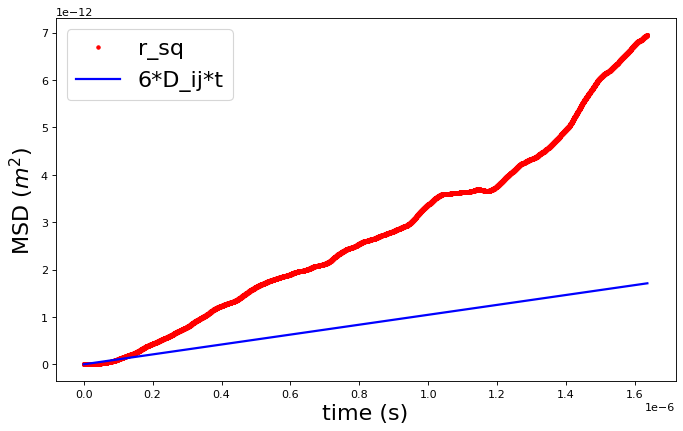

(<matplotlib.legend.Legend at 0x7faccc440520>, None)

In [22]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(time, r_sq,". r",label="r_sq")
D_ij = ftp_model.Diff_ij/2
ax1.plot(time, 6*D_ij*(time-time[0]),"-b", linewidth=2,label="6*D_ij*t")
ax1.set_xlabel('time (s)', fontsize=20)
ax1.set_ylabel('MSD ($m^2$)', fontsize=20)
plt.legend(fontsize=20, loc=0), plt.show()

In [40]:
# Check random numbers
n=10000
r_method1 = np.zeros(n)
r_method2 = np.zeros(n)
r_python = np.zeros(n)

for i in range(n):
    r_python[i] = np.random.normal(0,1)
    r_method1[i] = ftp.Get_normal_random(0,1)
    r_method2[i] = ftp_model.Get_Gaussian(0,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


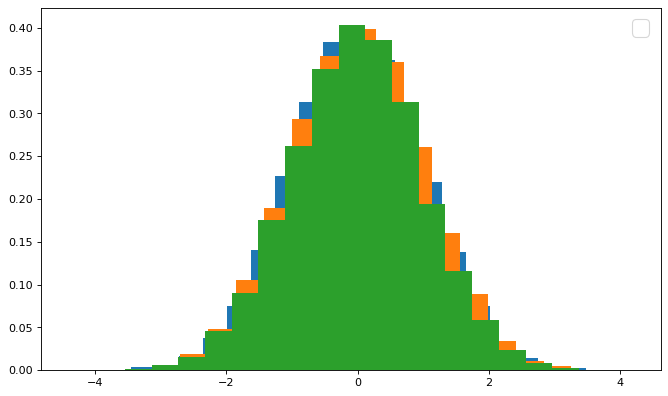

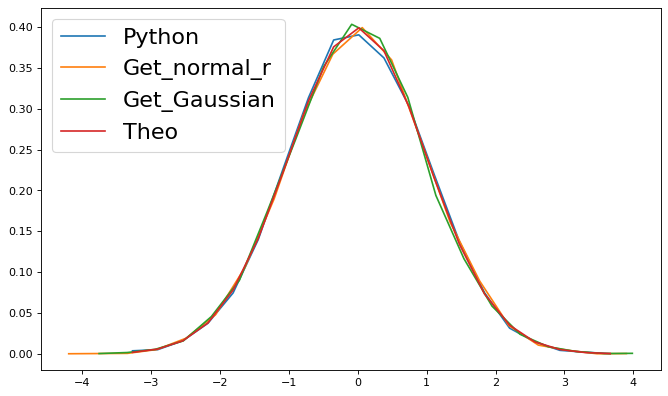

(<matplotlib.legend.Legend at 0x7faca98fc730>, None)

In [55]:
from scipy.stats import norm

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
count_rp,bins_rp,_ = plt.hist(r_python,bins=20,density=True)
count_r1,bins_r1,_ = plt.hist(r_method1,bins=20,density=True)
count_r2,bins_r2,_ = plt.hist(r_method2,bins=20,density=True)
plt.legend(fontsize=20, loc=0), plt.show()

bins_rp_c = np.zeros_like(count_rp)
bins_r1_c = np.zeros_like(count_r1)
bins_r2_c = np.zeros_like(count_r2)

for i in range(1,len(count_rp)+1):
    bins_rp_c[i-1] = (bins_rp[i-1]+bins_rp[i])*0.5
    bins_r1_c[i-1] = (bins_r1[i-1]+bins_r1[i])*0.5
    bins_r2_c[i-1] = (bins_r2[i-1]+bins_r2[i])*0.5

mu=0
std=1

p = norm.pdf(bins_rp_c, mu, std)

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(bins_rp_c, count_rp,label="Python")
plt.plot(bins_r1_c, count_r1,label="Get_normal_r")
plt.plot(bins_r2_c, count_r2,label="Get_Gaussian")
plt.plot(bins_rp_c, p,label="Theo")
plt.legend(fontsize=20, loc=0), plt.show()